<a href="https://colab.research.google.com/github/skitw427/Layerwise-XAI/blob/main/notebook_demo/ResNet18_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import timm
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import matplotlib.pylab as plt
import numpy as np
import random
import ast
import os

Device: cuda


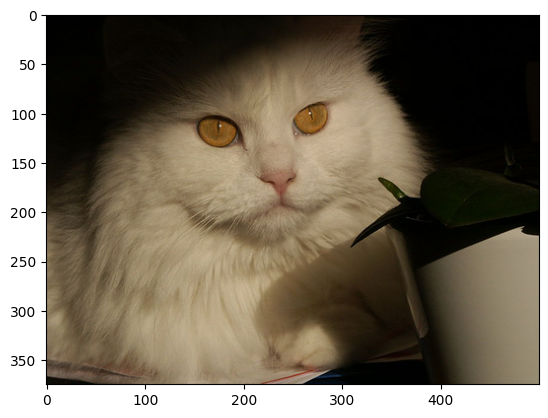

Top-5 Predictions:
Class: 283, Probability: 0.9764
Class: 760, Probability: 0.0026
Class: 761, Probability: 0.0013
Class: 457, Probability: 0.0008
Class: 478, Probability: 0.0008


In [5]:
def load_image(directory_path):
    files = sorted(os.listdir(directory_path))
    if not files:
        raise FileNotFoundError(f"No files found in the directory: {directory_path}")

    first_image_path = os.path.join(directory_path, files[0])
    if not os.path.isfile(first_image_path):
        raise ValueError(f"The first file in the directory is not a valid file: {first_image_path}")

    image = Image.open(first_image_path).convert("RGB")
    return image

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model_name = "resnet18.a1_in1k"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = timm.create_model(model_name, pretrained=True)
model = model.to(device)
model.eval()

image_directory = "cat/"

image = load_image(image_directory)
plt.imshow(image)
plt.show()

input_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_tensor)

softmax = torch.nn.Softmax(dim=1)
predictions = softmax(output)
top5_prob, top5_catid = torch.topk(predictions, 5)

print("Top-5 Predictions:")
for i in range(5):
    class_id = top5_catid[0][i].item()
    probability = top5_prob[0][i].item()
    print(f"Class: {class_id}, Probability: {probability:.4f}")


In [6]:
import os

image_dir = 'cat_train/'

image_tensors = []
for filename in os.listdir(image_dir):
    if filename.endswith('.JPEG'):
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image)
        image_tensors.append(image_tensor)

if image_tensors:
    train_input_tensor = torch.stack(image_tensors)
    print(f"Input tensor shape: {train_input_tensor.shape}")
else:
    print("No JPEG images found in the specified directory.")


image_dir = 'cat/'

image_tensors = []
for filename in os.listdir(image_dir):
    if filename.endswith('.JPEG'):
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image)
        image_tensors.append(image_tensor)

if image_tensors:
    val_input_tensor = torch.stack(image_tensors)
    print(f"Input tensor shape: {val_input_tensor.shape}")
else:
    print("No JPEG images found in the specified directory.")

Input tensor shape: torch.Size([28, 3, 224, 224])
Input tensor shape: torch.Size([1, 3, 224, 224])


In [7]:
import torch.nn as nn

for name, module in model.named_modules():
    if isinstance(module, nn.ReLU):
        module.inplace = False

# print(model)

In [10]:
import shap
import time

background = train_input_tensor[:10]
test_images = val_input_tensor[0:1]

background = background.to(device)
test_images = test_images.to(device)

# 실행 시간 측정 시작
start_time = time.time()

e = shap.GradientExplainer(model, background)
shap_values = e.shap_values(test_images)

# 실행 시간 측정 종료
end_time = time.time()

# 실행 시간 출력
print(f"shap_values 계산에 걸린 시간: {end_time - start_time:.2f}초")


shap_values 계산에 걸린 시간: 571.56초


In [12]:
mean = [0.485, 0.456, 0.406]
std =  [0.229, 0.224, 0.225]

shap_values_for_class = shap_values[..., 283:284]
shap_numpy = list(np.transpose(shap_values_for_class, (4, 0, 2, 3, 1)))
test_images_np = test_images.detach().cpu().numpy()  # torch.Tensor -> np.ndarray

for b in range(test_images_np.shape[0]):  # 배치 차원 순회
    for c in range(test_images_np.shape[1]):  # 채널(R/G/B)
        test_images_np[b, c, :, :] = test_images_np[b, c, :, :] * std[c] + mean[c]
test_images_np = test_images_np.transpose(0, 2, 3, 1)

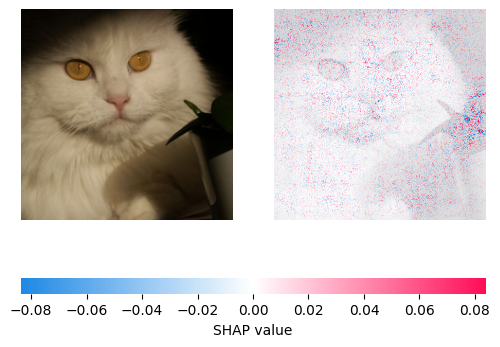

In [13]:
# plot the feature attributions
shap.image_plot(shap_numpy, test_images_np)